<a href="https://colab.research.google.com/github/Yuri-Vlasqz/Imersao_de_dados_Alura_2022/blob/main/Imers%C3%A3o_de_dados_Alura_(2022)_aulas_%2B_desafios_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **4º Imersão de dados Alura (2022)**
**Aula 5**

Instrutores:
---
- Thiago Gonçalves - Machine Learning Engineering Manager na Creditas
- Vivian Yamassaki - Lead Data Scientist I na Creditas
- Paulo Silveira - Co-fundador e CEO da Alura
___
Autor: Yuri Velasquez
---
[Github](https://github.com/Yuri-Vlasqz)

___
Datasets utilizado:
- imoveis_tratados

In [ ]:
# Instalação de bibliotecas
!pip install geopandas

# Importação de blibliotecas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
import time

# Parâmetros Globais
pd.set_option('display.float_format', lambda x: '%.2f' %x)
pd.set_option("max_columns", None)
sns.set()

# Link Datasets
path = "/content/drive/MyDrive/Imersão_de_dados_Alura_(2022)/Datasets gerados/imoveis_tratados.csv"

In [ ]:
def corr_matrix(data, cmap='divergent'):
    """
    It reads a dataframe and show a Lower Triangle Correlation Matrix.

    Parameters
    ----------
    data: dataframe
        Tabela ou colunas da tabela a serem correlacionadas (tipo numerico)
    cmap: string 
        Representa o mapa de cores (default='divergent' or 'sequencial')
        
    Returns
    -------
    matriz: None
        Mostra a matriz de correlação na chamada da função
        
    Examples
    --------
    corr_matrix(data[lista_colunas], 'cmap')
    """    

    # Lower Triangle Correlation Matrix
    corr_df = data.corr()
    corr_shape = corr_df.shape
    tri_df = corr_df.where(np.tril(np.ones(corr_shape)).astype(bool))

    # Figure Ploting parameters
    if cmap == "sequential":
        cmap = "rocket"
    else:
        cmap = "coolwarm"

    plt.figure(figsize=(corr_shape))
    sns.heatmap(tri_df, linewidths=0.5, annot=True, cmap=cmap)
    plt.title('Correlation Matrix')
    plt.xticks(rotation=40, ha='right')

    return

## Aula 5: Modelo Preditivo

In [ ]:
# Lendo dados de imoveis tratados
path = "/content/drive/MyDrive/Imersão_de_dados_Alura_(2022)/Datasets gerados/imoveis_tratados.csv"
imoveis_drive = pd.read_csv(path)
imoveis_tratados = imoveis_drive.drop(imoveis_drive.columns[[0]], axis=1)
display(imoveis_tratados.head(), imoveis_tratados.shape)

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Preco_m2,rua_e_bairro,cep,latitude,longitude,Point,setor_censo,Cod_distrito,Nome_do_distrito,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7000.00,avenida itacira - planalto paulista,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067.00,355030877.00,SAÚDE,1.00,0.00,164.00,437.00,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,7459.68,rua aurelia perez alvarez - jardim dos estados,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00,355030871.00,SANTO AMARO,1.00,0.00,136.00,425.00,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,3040.00,rua alba valdez - jardim reimberg,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00,355030830.00,GRAJAÚ,1.00,0.00,142.00,493.00,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,5400.00,rua tobias barreto - mooca,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050.00,355030808.00,BELÉM,1.00,0.00,156.00,468.00,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,1980000.00,4500.00,rua graham bell - santo amaro,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169.00,355030865.00,RAPOSO TAVARES,1.00,0.00,107.00,376.00,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46


(4794, 31)

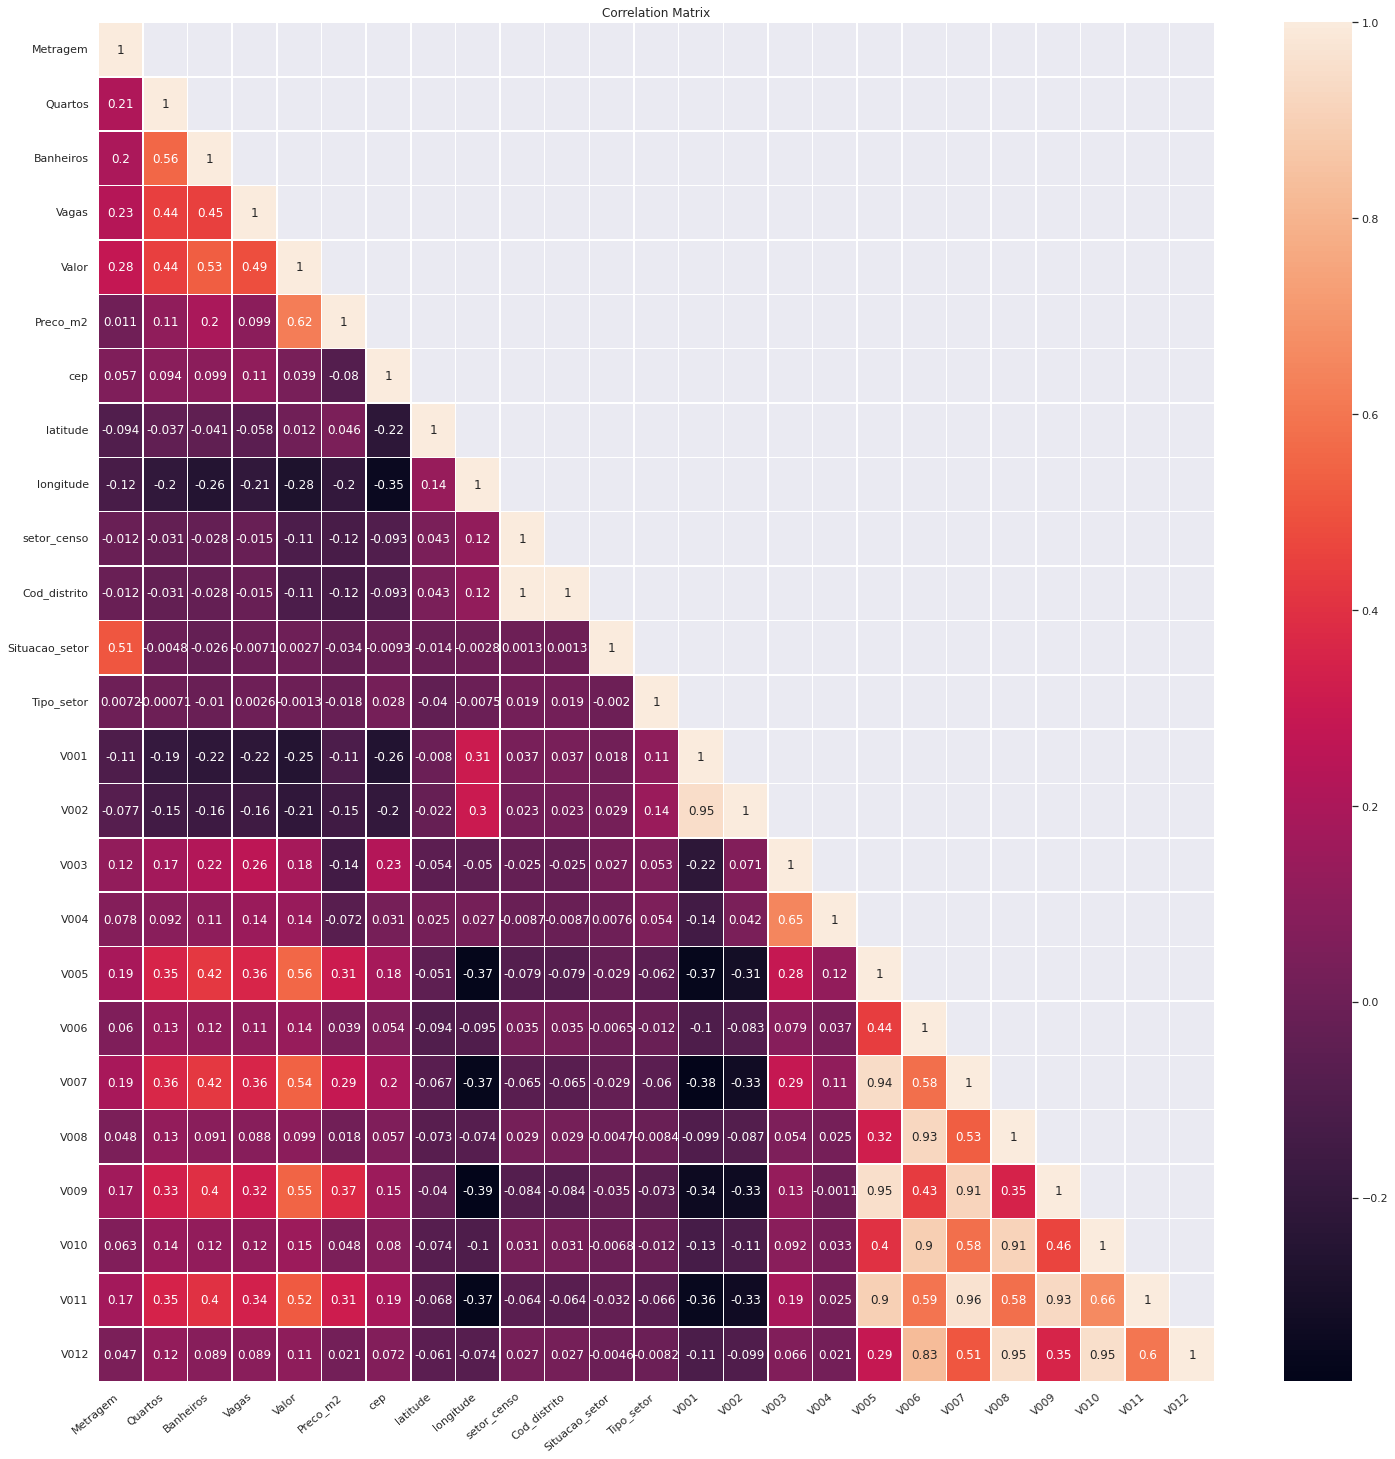

In [ ]:
corr_matrix(imoveis_tratados,'sequential')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

X = imoveis_tratados[['Metragem','Quartos','Banheiros','Vagas','V005']]
Y = imoveis_tratados["Valor"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 54)
lr = LinearRegression()
lr.fit(X_train, Y_train)

Y_predict_test = lr.predict(X_test)
Y_predict_train = lr.predict(X_train)

mae_test = mean_absolute_error(Y_test, Y_predict_test)
r2_test = r2_score(Y_test, Y_predict_test)
mae_train = mean_absolute_error(Y_train, Y_predict_train)
r2_train = r2_score(Y_train, Y_predict_train)

In [ ]:
mae_test

1038344.6839011216

In [ ]:
r2_test

0.46095867507033617

In [ ]:
mae_train

1005096.2271184284

In [ ]:
r2_train

0.4816642867697567

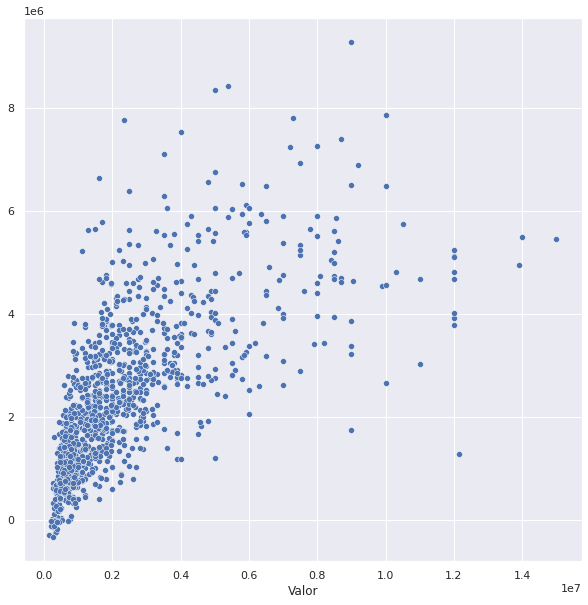

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=Y_test, y=Y_predict_test)

## Desafio Aula 5

1 - Adicionar o valor "real" do m2 do imóvel. 

2 - Testar outro modelos de regressão.

3 - Criar um modelo baseline com as features originais.

4 - Trabalhar um pouco mais nos dados e criar novas variáveis.

5 - Testar as predições para casos reais. 

6 - Criar um projeto com os resultados da imersão. Postar nas redes sociais mostrando o trabalho realizado. 